In [10]:
# Question 0
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd
from os.path import exists
file = 'tooth_growth.feather'
if exists(file):
    tg_data = pd.read_feather(file)
else:
    tg_data = sm.datasets.get_rdataset('ToothGrowth')
    tg_data = tg_data.data
    tg_data.to_feather(file)
data = tg_data
tg_data.head()

,len,supp,dose
0,4.2,VC,0.5
1,11.5,VC,0.5
2,7.3,VC,0.5
3,5.8,VC,0.5
4,6.4,VC,0.5


In [14]:
data['logY'] = np.log(data['len'])
cate = data['dose'].unique()
data['suppd'] = data['supp'].apply(lambda x: 1 if x == 'VC' else 0) 
data['X_dose'] = pd.Categorical(data['dose'])
X_1 = data['suppd']
X_2 = data['X_dose']
LR = smf.ols(formula = 'logY ~ suppd + X_dose + suppd: X_dose', data = data).fit()
LR.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   logY   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     41.69
Date:                Sat, 06 Nov 2021   Prob (F-statistic):           2.34e-17
Time:                        02:59:32   Log-Likelihood:                 4.2612
No. Observations:                  60   AIC:                             3.478
Df Residuals:                      54   BIC:                             16.04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               2.5326      0.075     33.711      0.000       2.382       2.683
X_dose[T.1.0]           0.5745      0.106      5.407      0.000       0.362       0.788
X_dose[T.2.0]           0.7232      0.106      6.807      0.000       0.510       0.936
suppd                  -0.5118      0.106     -4.817      0.000      -0.725      -0.299
suppd:X_dose[T.1.0]     0.2148      0.150      1.430      0.159      -0.086       0.516
suppd:X_dose[T.2.0]     0.5041      0.150      3.355      0.001       0.203       0.805
==============================================================================
Omnibus:                        0.136   Durbin-Watson:                   1.862
Prob(Omnibus):                  0.934   Jarque-Bera (JB):                0.039
Skew:                          -0.058   Prob(JB):                        0.981
Kurtosis:                       2.953   Cond. No.                         9.77
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
# calculation R square and adjusted R square
Y_hat = LR.predict()
SSE = np.sum((data['logY'] - Y_hat)**2)
SSR = np.sum((Y_hat - np.mean(data['logY']))**2)
SSY = SSE + SSR
R_square = SSR / (SSY)
R_square

0.7942457970936074

In [30]:
# degree freedom of  SSE : 54, degree freedom of SSY : 59
Adjusted_Rsquare = 1- (SSE / 54) / (SSY / 59)
Adjusted_Rsquare

# Comments 
## Computation results of Rsquare and adjusted Rsquare are the same as shown in result object.

0.7751944820096822

In [7]:
# Question 1
## (a)
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np
import warnings
import pickle
import patsy
from matplotlib import pyplot as plt
warnings.filterwarnings("ignore")
# demography data
demogr = pickle.load(open('./demogr_total.pkl','rb'))
# oral health data
orl_halh = pickle.load(open('./oral_dentition_total.pkl','rb')) 

In [8]:
data_all = pd.merge(demogr, orl_halh, on = 'id')
orl_halh.head()

,id,status code,ohx01tc,ohx02tc,ohx03tc,ohx04tc,ohx05tc,ohx06tc,ohx07tc,ohx08tc,...,ohx23ctc,ohx24ctc,ohx25ctc,ohx26ctc,ohx27ctc,ohx28ctc,ohx29ctc,ohx30ctc,ohx31ctc,type
0,62161.0,1.0,4.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,S,S,S,S,S,S,S,Z,S,11-12
1,62162.0,1.0,4.0,4.0,4.0,1.0,1.0,1.0,1.0,1.0,...,D,D,D,D,D,D,D,U,U,11-12
2,62163.0,1.0,4.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,S,S,S,S,S,S,S,Y,S,11-12
3,62164.0,1.0,4.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,S,S,S,S,S,S,S,Z,Z,11-12
4,62165.0,1.0,4.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,S,S,S,S,S,S,S,S,S,11-12


In [26]:
# I pick tooth 1: ohx01TC as response variable Y.
## From the expression of question, we should use 'age' as predictor and Y as response variable to build logistic regression.
## To prevent ineffective fit, I just use people aged above 12 since people below 12 have no permanent tooth.

data_all = data_all.loc[data_all['age'] > 12, :]
data_all['ohx01tc_y'] = data_all['ohx01tc'].apply(lambda x: 1 if x == 2 else 0)
X = data_all['age']
kmin = np.min(X)
kmax = np.max(X)
print('minimum age is :', kmin,'\n', 'maximum age is :', kmax)
# age [1, 80], test for a few sets of knots, make selection of best set by 'aic' index.
knot_dict = {}
# random seed to certain generated results
np.random.seed(10)
for i in range(10):
    knot_dict[str(i)] = np.random.randint(15, 75, 5)
knot_dict['10'] = [15, 25, 35, 45, 55]
aiclist = []
for j in knot_dict.keys():
    knots = knot_dict[j]
    # here I groupby age first to get average permanent tooth probability in each age group, so I use this as y and age as x
    # to build a ols regression, which is equal to logit.
    logitm = smf.ols('ohx01tc ~ patsy.bs(age, knots = knots, degree = 3)', data = data_all).fit()
    aiclist.append(logitm.aic)
minaic = min(aiclist)
min_index = aiclist.index(min(aiclist))
knots = knot_dict[str(min_index)] # knots of minimum aic model
logitmodel = smf.logit(' ohx01tc_y ~ patsy.bs(age, knots = knots, degree = 3)', data = data_all).fit()
logitmodel.summary()
print('Minimum Aic is :', min(aiclist),'\n')
print('knots are:', np.sort(knots))

minimum age is : 13.0 
 maximum age is : 80.0
Optimization terminated successfully.
         Current function value: 0.458229
         Iterations 9
Minimum Aic is : 58670.82861659549 

knots are: [20 28 28 66 69]


In [27]:
# Control for demographic data, add variable gender as a confounder
# I use 'race' for demographic data as warranted because different races may have different tooth conditions,
# adding race may have more information so that information loss can be less, which makes a smaller AIC value.
# After adding race, minimum AIC decreased from 58670 to only 23043, which shows a much better fit result.

logitinter = smf.logit('ohx01tc_y ~ patsy.bs(age, knots = knots, degree = 3) * race', data = data_all).fit()
print(logitinter.summary(),'\n')
print('AIC after adding race is:', logitinter.aic)

Optimization terminated successfully.
         Current function value: 0.440721
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:              ohx01tc_y   No. Observations:                26020
Model:                          Logit   Df Residuals:                    25966
Method:                           MLE   Df Model:                           53
Date:                Sun, 07 Nov 2021   Pseudo R-squ.:                  0.1129
Time:                        23:00:11   Log-Likelihood:                -11468.
converged:                       True   LL-Null:                       -12927.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
Intercept                

In [30]:
## (b)
## To show fitted values in a more clear way, I use 'groupby' function to average fitted probability within each age.

knots = [20, 28, 66, 69] # best knots in (a)
tooth_variables = ['ohx' + str(i + 1).zfill(2) + 'tc' for i in range(32)]
fittedvalue = pd.DataFrame()
for i in range(len(tooth_variables)):
    groupname = tooth_variables[i] + str(i+1)
    data_all[groupname] = data_all[tooth_variables[i]].apply(lambda x: 1 if x == 2 else 0)  
    name = 'proby' + str(i + 1)
    log_data[name] = data_all.groupby(['age'])[groupname].mean()
    logitm = smf.logit(groupname + ' ~ patsy.bs(age, knots = knots, degree = 3)', data = data_all).fit()
    fitname = 'yhat' + str(i + 1)
    data_all['predict'+ str(i + 1)] = logitm.predict()
    fittedgroup = data_all.groupby(['age'])['predict'+ str(i + 1)].mean()
    fittedvalue[fitname] = fittedgroup

# display 
pd.options.display.float_format = '{:.5f}'.format
display(fittedvalue)



Optimization terminated successfully.
         Current function value: 0.458233
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.487302
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.472903
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.465501
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.515515
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.408534
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.426915
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.416997
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.415329
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.424754
  

,yhat1,yhat2,yhat3,yhat4,yhat5,yhat6,yhat7,yhat8,yhat9,yhat10,...,yhat23,yhat24,yhat25,yhat26,yhat27,yhat28,yhat29,yhat30,yhat31,yhat32
age,,,,,,,,,,,,,,,,,,,,,
13.00000,0.00128,0.83494,0.97661,0.94561,0.94887,0.92120,0.97040,0.97723,0.97706,0.96990,...,0.97622,0.97837,0.97454,0.97536,0.96951,0.95846,0.93527,0.97330,0.90735,0.00307
14.00000,0.00654,0.92444,0.97769,0.96186,0.93729,0.95392,0.97204,0.97915,0.97891,0.97241,...,0.97771,0.97955,0.97598,0.97713,0.97511,0.95004,0.95535,0.97487,0.94988,0.01453
15.00000,0.02306,0.95535,0.97697,0.96887,0.92703,0.96703,0.97199,0.97942,0.97905,0.97294,...,0.97774,0.97928,0.97605,0.97726,0.97741,0.94210,0.96426,0.97406,0.96536,0.04622
16.00000,0.05869,0.96631,0.97470,0.97116,0.91862,0.97195,0.97061,0.97844,0.97787,0.97199,...,0.97662,0.97784,0.97505,0.97614,0.97766,0.93497,0.96757,0.97121,0.97039,0.10372
17.00000,0.11294,0.96900,0.97095,0.97050,0.91216,0.97266,0.96809,0.97638,0.97556,0.96981,...,0.97455,0.97538,0.97317,0.97397,0.97643,0.92882,0.96753,0.96634,0.97009,0.17513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76.00000,0.09133,0.34153,0.37651,0.41777,0.43342,0.54928,0.49383,0.52030,0.52509,0.51953,...,0.63449,0.59921,0.59939,0.63071,0.67402,0.58788,0.48943,0.34502,0.35089,0.12969
77.00000,0.08336,0.33220,0.36776,0.40507,0.42446,0.53775,0.48288,0.51016,0.51453,0.50898,...,0.62564,0.58993,0.58966,0.62138,0.66483,0.57759,0.48030,0.33976,0.34440,0.12167
78.00000,0.07362,0.32442,0.35788,0.39155,0.41461,0.52348,0.47125,0.49654,0.50007,0.49395,...,0.61614,0.58188,0.58034,0.61165,0.65534,0.56746,0.47078,0.33122,0.33731,0.11120


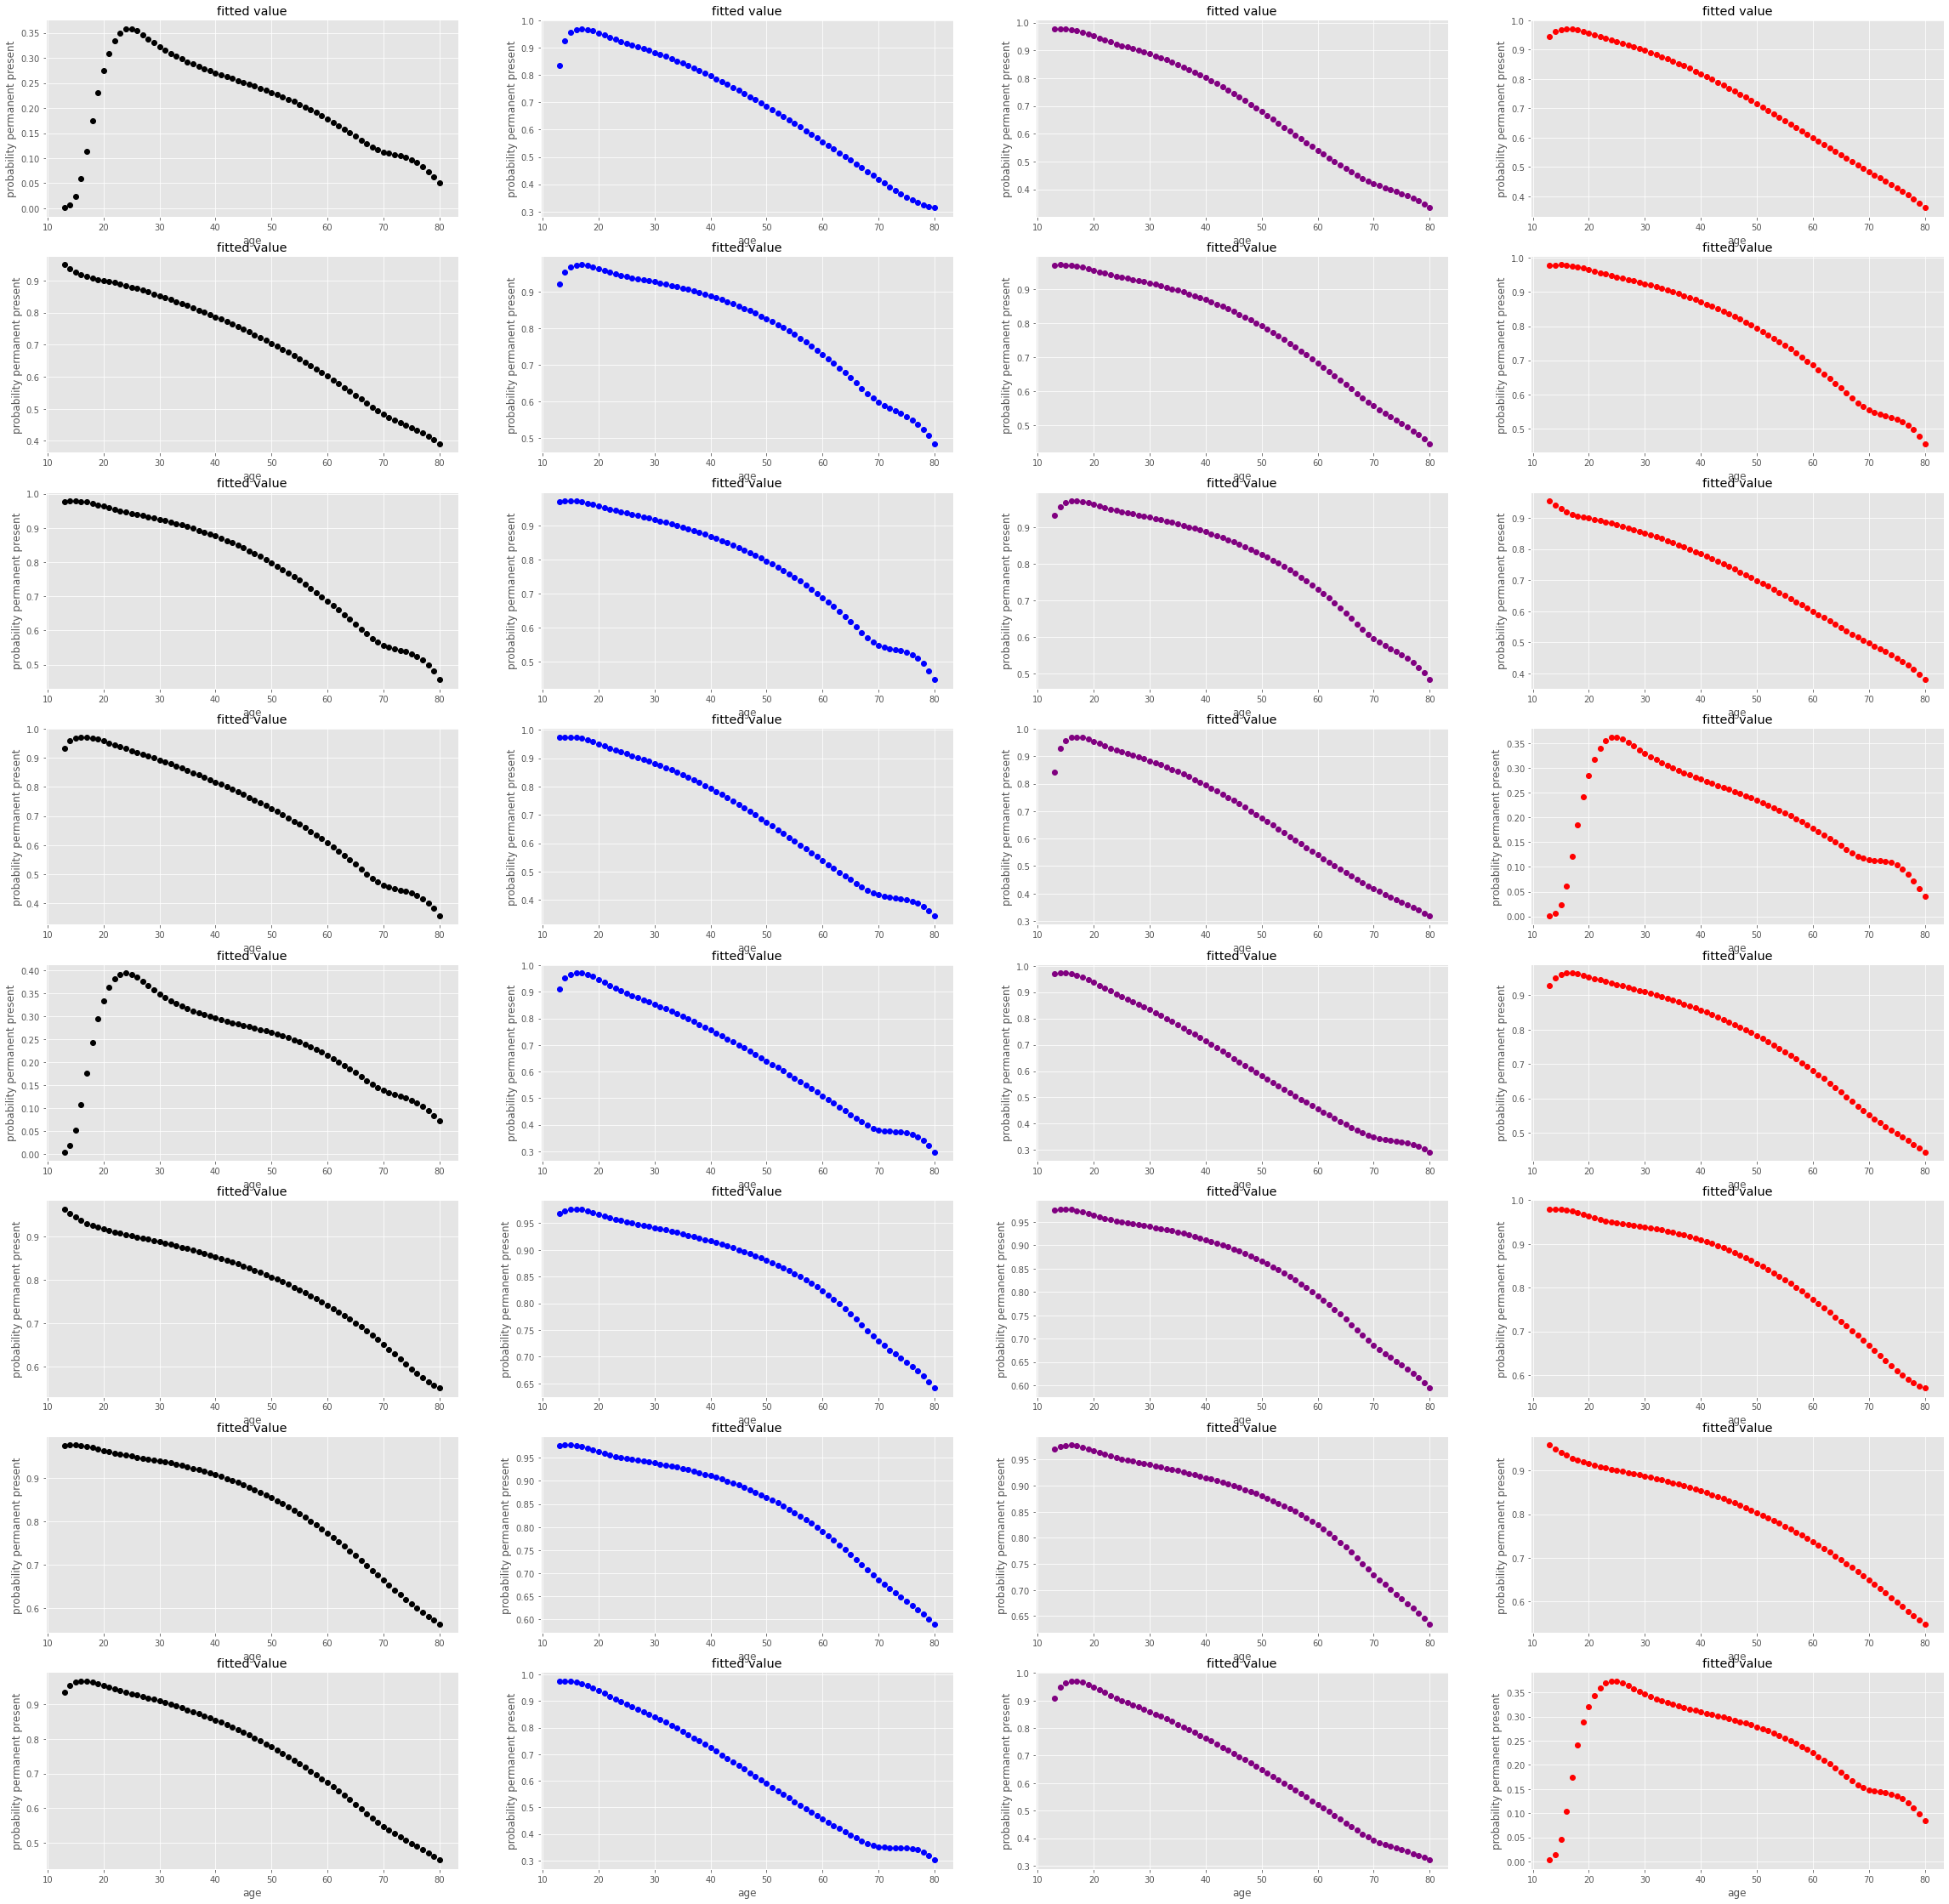

In [33]:
## (c)
# Suppose there are 32 kinds of tooth count, so set up a 4 * 8 subplot set.
plt.figure(800 * 800)
plt.rcParams['figure.figsize'] = (40, 40)
plt.style.use('ggplot')
plt.style.context('dark')
col = ['red', 'black', 'blue', 'purple']
X = np.arange(13, 81, 1)
for i in range(32):
    ax = plt.subplot(8, 4, (i + 1))
    ax.scatter(X, fittedvalue.iloc[:, i], linewidth = 1, color = col[(i + 1) % 4])
    ax.set_ylabel('probability permanent present')
    ax.set_xlabel('age')
    ax.set_title('fitted value')
    

In [55]:
# Question 2
## Since in 1a I select tooth 'ohx01tc' as x, so I split this into 10 groups by quantile.
### 1
q = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
probfit = logitmodel.predict()
quantiles = np.quantile(probfit, q)
bindict = {}
bindict['q1'] = probfit[probfit <= quantiles[0]] 
indexdict = {}
indexdict['q1'] = np.where(probfit <= quantiles[0])
for i in range(8):
    indexdict['q' + str(i + 2)] = np.where((probfit > quantiles[i]) & (probfit <= quantiles[i + 1]))
    bindict['q' + str(i + 2)] = probfit[(probfit > quantiles[i]) & (probfit <= quantiles[i + 1])]
indexdict['q10'] = np.where(probfit > quantiles[8])    
bindict['q10'] = probfit[probfit > quantiles[8]] 
bindict

{'q1': array([0.00671805, 0.00671805, 0.02306323, ..., 0.00671805, 0.02306323,
        0.00671805]),
 'q2': array([0.05805348, 0.05805348, 0.08304974, ..., 0.1052556 , 0.09726469,
        0.09726469]),
 'q3': array([0.11176952, 0.11297824, 0.11176952, ..., 0.11022347, 0.13602239,
        0.11297824]),
 'q4': array([0.16448365, 0.1433278 , 0.15758297, ..., 0.17120623, 0.16448365,
        0.1433278 ]),
 'q5': array([0.20718086, 0.19605861, 0.21241867, ..., 0.20718086, 0.17773515,
        0.20718086]),
 'q6': array([0.22693443, 0.23074479, 0.23141458, ..., 0.21744985, 0.23993261,
        0.23993261]),
 'q7': array([0.2557652 , 0.25960704, 0.26345342, ..., 0.25960704, 0.26345342,
        0.2673318 ]),
 'q8': array([0.29294555, 0.29294555, 0.28823912, ..., 0.27688606, 0.27529978,
        0.27944956]),
 'q9': array([0.31239042, 0.29790612, 0.32103501, ..., 0.31468199, 0.31468199,
        0.30315711]),
 'q10': array([0.33718923, 0.35120784, 0.33513013, ..., 0.35120784, 0.35765713,
        0.3

In [91]:
### 2
observeddict = {}
expecteddict = {}
for j in range(10):
    count = 0
    length = len(indexdict['q' + str(j + 1)][0])
    for i in range(length):
        count += data_all['ohx01tc_y'].iloc[indexdict['q' + str(j + 1)][0][i]]
    observeddict['q' + str(j + 1)] = count / length
    expecteddict['q' + str(j + 1)] = np.mean(bindict['q' + str(j + 1)])
print('observed proportion:', observeddict)
print('expected proportion:', expecteddict)

observed proportion: {'q1': 0.024947400060114217, 'q2': 0.08288110508140109, 'q3': 0.11769172361427487, 'q4': 0.16799393249905195, 'q5': 0.1885846509834169, 'q6': 0.23165735567970205, 'q7': 0.2525651144435675, 'q8': 0.28137490007993604, 'q9': 0.3135956369302688, 'q10': 0.34725536992840095}
expected proportion: {'q1': 0.026871320249777054, 'q2': 0.07910412958388335, 'q3': 0.11825191789042075, 'q4': 0.1616855318575124, 'q5': 0.19531767786486998, 'q6': 0.22929347184628687, 'q7': 0.2558428539138276, 'q8': 0.28109452956980335, 'q9': 0.31229387592613744, 'q10': 0.3476691936023328}


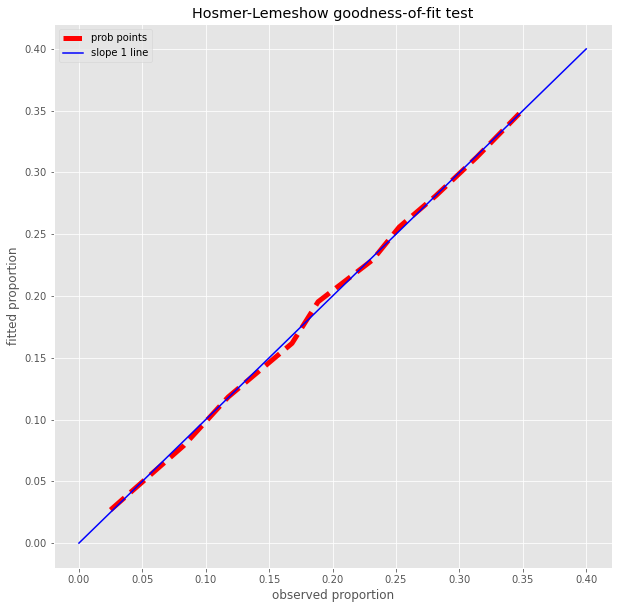

In [120]:
### 3
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams["legend.loc"]
X = list(observeddict.values())
Y = list(expecteddict.values())
# y = x with slope 1
X1 = np.linspace(0, 0.4, 101)
Y1 = np.linspace(0, 0.4, 101)
plt.plot(X, Y, '--', color = 'red', linewidth = 5, label = 'prob points')
plt.plot(X1, Y1, color = 'blue', label = 'slope 1 line')
plt.xlabel('observed proportion')
plt.ylabel('fitted proportion')
plt.title('Hosmer-Lemeshow goodness-of-fit test')
plt.legend()
plt.show()
    

In [ ]:
### 4
## Comment: From figures drawn in question 3, we can see observed probabilities and fitted probabilities in each decile
## are almost shaped as a line with slope 1. So the fitted result is very good.